In [ ]:
!pip install clearml
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=your_key
%env CLEARML_API_SECRET_KEY=your_key

In [3]:
import torchvision
import torch
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from zipfile import ZipFile
import random
import PIL
import os
from clearml import Task
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [4]:
task = Task.init(project_name='kfu mushrooms classification', task_name='mobileNet', task_type=Task.TaskTypes.training)

ClearML Task: created new task id=7011b75419a943de891f240ae82df314
ClearML results page: https://app.clear.ml/projects/21c6d44dcb0744709059cdf0b73edfa9/experiments/7011b75419a943de891f240ae82df314/output/log
2024-04-26 16:29:00,446 - clearml.Task - INFO - Storing jupyter notebook directly as code


/usr/local/lib/python3.10/dist-packages/clearml/utilities/process/mp.py:622: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [5]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [6]:
!git clone -b develop https://github.com/sevdaisk/Mushroom-recognition.git

Cloning into 'Mushroom-recognition'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (593/593), done.
remote: Compressing objects: 100% (593/593), done.
remote: Total 4056 (delta 0), reused 592 (delta 0), pack-reused 3463
Receiving objects: 100% (4056/4056), 49.59 MiB | 30.48 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [7]:
input_dir = '/content/Mushroom-recognition'
batch_size = 32
rescale_size = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
!rm -r /content/Mushroom-recognition/*.py
!rm -r /content/Mushroom-recognition/.git
!rm -r /content/Mushroom-recognition/.idea
!rm -r /content/Mushroom-recognition/.ipynb_checkpoints

rm: cannot remove '/content/Mushroom-recognition/.ipynb_checkpoints': No such file or directory


In [9]:
transform = transforms.Compose([
    transforms.Resize((int(rescale_size), int(rescale_size))),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.8),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
dataset_full = torchvision.datasets.ImageFolder(root=input_dir, transform=transform)

# split full dataset
train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.9)
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}
dataset_classes = np.array(dataset_full.classes)
print('classes:', dataset_classes, '\nsize', dataset_size)

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=batch_size, shuffle=False
    ),
}

classes: ['false honey mushrooms' 'morel' 'panther fly agaric' 'red fly agaric'
 'white toadstool' 'Вешенки' 'Волнушки' 'Желтая сыроежка' 'Желчный гриб'
 'Зеленая сыроежка' 'Красная сыроежка' 'Лисички' 'Маслята' 'Опята'
 'Шампиньоны' 'белый гриб' 'груздь белый' 'груздь черный' 'подберезовик'
 'подосиновик'] 
size {'train': 3600, 'valid': 400}


In [11]:
task.connect(dataset_full)

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /content/Mushroom-recognition
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               RandomPerspective(p=0.8)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
id2class = {i: cls for i, cls in enumerate(dataset_classes)}

In [13]:
tensorboard_writer = SummaryWriter('./tensorboard_logs')

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
from collections import namedtuple
from typing import NamedTuple, List

EvalOut = namedtuple("EvalOut", ['loss', 'accuracy'])
os.makedirs('/content/mushroom_logs', exist_ok=True)

def eval_epoch(
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    loader: torch.utils.data.DataLoader,
    device: torch.device
):
    acc_loss = 0
    accuracy = 0
    total = len(loader.dataset)
    model.eval()
    model.to(device)
    with torch.inference_mode():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            acc_loss += loss.item()
            accuracy += torch.sum(torch.argmax(pred, 1) == target).item()

    return EvalOut(loss = (acc_loss / total), accuracy = (accuracy / total))


class TrainOut(NamedTuple):
    train_loss: List[float]
    eval_loss: List[float]
    eval_accuracy: List[float]


def train(
    model: torch.nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss._Loss,
    sheduler: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    epochs: int = 10
):
    # Подключение параметров конфигурации к задаче ClearML
    configuration_dict = {'number_of_epochs': epochs, 'batch_size': batch_size, 'base_lr': 1e-4, 'weight_decay': 1e-4, 'rescale_size': 64}
    task.connect(configuration_dict)

    train_loss = []
    eval_loss = []
    eval_accuracy = []
    model.to(device)
    for i in range(epochs):
        print(f"Epoch - {i}\n")
        if (train_loader != None):
            print("Train...\n")
            train_loss.append(train_epoch(model, optimizer, criterion, train_loader, device))
            tensorboard_writer.add_scalar('loss/training', train_loss[-1], i)
            # Отчеты метрик обучения в ClearML
            task.get_logger().report_scalar(series='loss', title='training', value=train_loss[-1], iteration=i)
        print("Validation...\n")
        eval_out = eval_epoch(model, criterion, val_loader, device)
        eval_loss.append(eval_out.loss)
        eval_accuracy.append(eval_out.accuracy)
        tensorboard_writer.add_scalar('validation accuracy', eval_out.accuracy, i)
        tensorboard_writer.add_scalar('loss/validation', eval_out.loss, i)
        # Отчеты метрик валидации в ClearML
        task.get_logger().report_scalar(series='accuracy', title='validation', value=eval_out.accuracy, iteration=i)
        task.get_logger().report_scalar(series='loss', title='validation', value=eval_out.loss, iteration=i)
        print(f'Validation acc: {eval_out.accuracy}')
        sheduler.step()
        print('lr: ', get_lr(optimizer))
        # Отчеты скорости обучения в ClearML
        task.get_logger().report_scalar(series='learning_rate', title='learning_rate', value=get_lr(optimizer), iteration=i)
        if i > 1 and eval_accuracy[i] == max(eval_accuracy) and i % 3 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  }, f'/content/mushroom_logs/epoch_{i}.pth')
            task.upload_artifact('/content/mushroom_logs', 'trained_models')

    return TrainOut(train_loss = train_loss,
                    eval_loss = eval_loss,
                    eval_accuracy = eval_accuracy), model

In [16]:
def show_losses(TrainOut, epochs):
    plt.plot(epochs, TrainOut.train_loss)
    plt.plot(epochs, TrainOut.eval_loss)
    plt.show()

def show_accuracy(accuracy, epochs):
    plt.plot(epochs, accuracy)
    plt.show()

In [17]:
def predict(model, dataloader_test):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader_test:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [18]:
import torchvision.transforms as T
from torchvision.models import mobilenet_v3_large
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V2')

class MobileNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V2')
    for param in self.mobilenet.parameters():
      param.requires_grad = False

    for j in range(15, 17):
      for param in self.mobilenet.features[j].parameters():
        param.requires_grad = True

    for param in self.mobilenet.classifier.parameters():
      param.requires_grad = True

    self.mobilenet.classifier[3] = torch.nn.Linear(1280, 20)

    self.transforms =  torch.nn.Sequential(
            T.Resize(224),  # We use single int value inside a list due to torchscript type restrictions
#            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x = self.transforms(x)
    y = self.mobilenet(x)
    return y

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 102MB/s]


2024-04-26 16:29:09,003 - clearml.model - INFO - Selected model id: b55d3f1e864a4476acefd8ed51a1f26e


In [19]:
from tqdm.notebook import tqdm

def train_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss._Loss,
    loader: torch.utils.data.DataLoader,
    device: torch.device
):
    acc_loss = 0
    total = len(loader.dataset)
    model.to(device)
    model.train()
    for data, target in tqdm(loader):
      # with accelerator.accumulate(model): # для имитации большого размера батча (полезно для трансформеров)
        data = data.to(device)
        target = target.to(device)
        pred = model(data)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        acc_loss += loss.item()
    for n, (img, pred, label) in enumerate(zip(data, pred, target)):
        if n == 31:
            tensorboard_writer.add_image("testing/{}_GT_{}_pred_{}"
                                          .format(n, id2class[int(label)], id2class[int(torch.argmax(pred, 1))]), img)
            task.get_logger().report_image("testing/{}_GT_{}_pred_{}".format(n, id2class[int(label)], id2class[int(torch.argmax(pred, 1))]), img, iteration=i)

    return acc_loss / total

In [20]:
model = MobileNet().to(device)

2024-04-26 16:29:14,336 - clearml.model - WARNING - Connecting multiple input models with the same name: `mobilenet_v3_large-5c1a4163`. This might result in the wrong model being used when executing remotely


In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
epochs = 130
configuration_dict = {'number_of_epochs': epochs, 'batch_size': batch_size, 'base_lr': 1e-4, 'weight_decay': 1e-4, 'rescale_size': 64}
tr_tuple, model = train(model, optimizer, criterion, sheduler, dataloader['train'], dataloader['valid'], device, epochs)

Epoch - 0

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.3125
lr:  9.900000000000001e-05
Epoch - 1

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.465
lr:  9.801e-05
Epoch - 2

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.545
lr:  9.70299e-05
Epoch - 3

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6025
lr:  9.605960100000001e-05
2024-04-26 16:32:17,880 - clearml.frameworks - INFO - Found existing registered model id=41b7d0ad18a1418cb0f477c7fb7dac93 [/content/mushroom_logs/epoch_3.pth] reusing it.
Epoch - 4

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.605
lr:  9.509900499000001e-05
Epoch - 5

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6525
lr:  9.414801494010001e-05
Epoch - 6

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.615
lr:  9.320653479069902e-05
Epoch - 7

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6975
lr:  9.227446944279203e-05
Epoch - 8

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6775
lr:  9.13517247483641e-05
Epoch - 9

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.69
lr:  9.043820750088047e-05
Epoch - 10

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.72
lr:  8.953382542587167e-05
Epoch - 11

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7075
lr:  8.863848717161295e-05
Epoch - 12

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7175
lr:  8.775210229989682e-05
Epoch - 13

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7325
lr:  8.687458127689785e-05
Epoch - 14

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.745
lr:  8.600583546412887e-05
Epoch - 15

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7675
lr:  8.514577710948758e-05
2024-04-26 16:41:36,198 - clearml.frameworks - INFO - Found existing registered model id=951498f04b7d496da75df205a7e3c5f9 [/content/mushroom_logs/epoch_15.pth] reusing it.
Epoch - 16

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7725
lr:  8.429431933839271e-05
Epoch - 17

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.785
lr:  8.345137614500879e-05
Epoch - 18

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.78
lr:  8.26168623835587e-05
Epoch - 19

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7625
lr:  8.17906937597231e-05
Epoch - 20

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.745
lr:  8.097278682212587e-05
Epoch - 21

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8075
lr:  8.016305895390461e-05
2024-04-26 16:46:29,294 - clearml.frameworks - INFO - Found existing registered model id=d6b3b0cca4884a8fa2c6252adcf943cf [/content/mushroom_logs/epoch_21.pth] reusing it.
Epoch - 22

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.77
lr:  7.936142836436556e-05
Epoch - 23

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7575
lr:  7.856781408072191e-05
Epoch - 24

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8075
lr:  7.778213593991469e-05
2024-04-26 16:48:59,634 - clearml.frameworks - INFO - Found existing registered model id=6ad96782c770428fb6d075d6fbd1b457 [/content/mushroom_logs/epoch_24.pth] reusing it.
Epoch - 25

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7725
lr:  7.700431458051554e-05
Epoch - 26

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8275
lr:  7.623427143471038e-05
Epoch - 27

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.795
lr:  7.547192872036328e-05
Epoch - 28

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8025
lr:  7.471720943315964e-05
Epoch - 29

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8475
lr:  7.397003733882805e-05
Epoch - 30

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8225
lr:  7.323033696543977e-05
Epoch - 31

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.845
lr:  7.249803359578537e-05
Epoch - 32

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8475
lr:  7.177305325982752e-05
Epoch - 33

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8175
lr:  7.105532272722923e-05
Epoch - 34

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.84
lr:  7.034476949995695e-05
Epoch - 35

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.84
lr:  6.964132180495738e-05
Epoch - 36

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8375
lr:  6.89449085869078e-05
Epoch - 37

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8525
lr:  6.825545950103872e-05
Epoch - 38

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8675
lr:  6.757290490602833e-05
Epoch - 39

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.83
lr:  6.689717585696805e-05
Epoch - 40

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.88
lr:  6.622820409839837e-05
Epoch - 41

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8325
lr:  6.556592205741439e-05
Epoch - 42

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.845
lr:  6.491026283684025e-05
Epoch - 43

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8725
lr:  6.426116020847184e-05
Epoch - 44

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.865
lr:  6.361854860638712e-05
Epoch - 45

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.83
lr:  6.298236312032325e-05
Epoch - 46

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.86
lr:  6.235253948912002e-05
Epoch - 47

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8625
lr:  6.172901409422881e-05
Epoch - 48

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8475
lr:  6.111172395328652e-05
Epoch - 49

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.86
lr:  6.050060671375366e-05
Epoch - 50

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  5.9895600646616125e-05
Epoch - 51

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.865
lr:  5.9296644640149966e-05
Epoch - 52

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8725
lr:  5.8703678193748465e-05
Epoch - 53

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.905
lr:  5.811664141181098e-05
Epoch - 54

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8775
lr:  5.753547499769287e-05
Epoch - 55

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.845
lr:  5.696012024771594e-05
Epoch - 56

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.88
lr:  5.639051904523878e-05
Epoch - 57

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8775
lr:  5.5826613854786396e-05
Epoch - 58

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.88
lr:  5.5268347716238534e-05
Epoch - 59

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8775
lr:  5.471566423907615e-05
Epoch - 60

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  5.416850759668539e-05
Epoch - 61

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8925
lr:  5.362682252071853e-05
Epoch - 62

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  5.309055429551135e-05
Epoch - 63

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8975
lr:  5.2559648752556236e-05
Epoch - 64

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8775
lr:  5.203405226503067e-05
Epoch - 65

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.875
lr:  5.1513711742380364e-05
Epoch - 66

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9075
lr:  5.099857462495656e-05
2024-04-26 17:23:41,555 - clearml.frameworks - INFO - Found existing registered model id=a3cffa61e2df4670afc5610d226e94c9 [/content/mushroom_logs/epoch_66.pth] reusing it.
Epoch - 67

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9175
lr:  5.0488588878706996e-05
Epoch - 68

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  4.9983702989919924e-05
Epoch - 69

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  4.9483865960020725e-05
Epoch - 70

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  4.898902730042052e-05
Epoch - 71

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8975
lr:  4.8499137027416314e-05
Epoch - 72

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.905
lr:  4.801414565714215e-05
Epoch - 73

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8875
lr:  4.753400420057073e-05
Epoch - 74

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.885
lr:  4.705866415856502e-05
Epoch - 75

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.86
lr:  4.658807751697937e-05
Epoch - 76

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.915
lr:  4.6122196741809574e-05
Epoch - 77

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9075
lr:  4.566097477439148e-05
Epoch - 78

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.89
lr:  4.520436502664756e-05
Epoch - 79

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8975
lr:  4.475232137638109e-05
Epoch - 80

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.915
lr:  4.430479816261728e-05
Epoch - 81

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9
lr:  4.3861750180991104e-05
Epoch - 82

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.925
lr:  4.3423132679181194e-05
Epoch - 83

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.92
lr:  4.298890135238938e-05
Epoch - 84

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9
lr:  4.255901233886549e-05
Epoch - 85

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8875
lr:  4.213342221547683e-05
Epoch - 86

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9
lr:  4.1712087993322064e-05
Epoch - 87

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9075
lr:  4.1294967113388845e-05
Epoch - 88

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9025
lr:  4.0882017442254956e-05
Epoch - 89

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.92
lr:  4.04731972678324e-05
Epoch - 90

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9075
lr:  4.006846529515408e-05
Epoch - 91

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  3.966778064220254e-05
Epoch - 92

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9175
lr:  3.927110283578051e-05
Epoch - 93

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9075
lr:  3.8878391807422704e-05
Epoch - 94

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.92
lr:  3.8489607889348474e-05
Epoch - 95

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9125
lr:  3.8104711810454986e-05
Epoch - 96

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.915
lr:  3.7723664692350434e-05
Epoch - 97

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.905
lr:  3.734642804542693e-05
Epoch - 98

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8875
lr:  3.697296376497266e-05
Epoch - 99

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8925
lr:  3.660323412732293e-05
Epoch - 100

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9225
lr:  3.62372017860497e-05
Epoch - 101

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.92
lr:  3.5874829768189206e-05
Epoch - 102

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.91
lr:  3.551608147050731e-05
Epoch - 103

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9125
lr:  3.516092065580224e-05
Epoch - 104

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.93
lr:  3.480931144924422e-05
Epoch - 105

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8925
lr:  3.4461218334751775e-05
Epoch - 106

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9275
lr:  3.4116606151404254e-05
Epoch - 107

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9225
lr:  3.377544008989021e-05
Epoch - 108

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.925
lr:  3.343768568899131e-05
Epoch - 109

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.895
lr:  3.31033088321014e-05
Epoch - 110

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9025
lr:  3.277227574378038e-05
Epoch - 111

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9225
lr:  3.244455298634257e-05
Epoch - 112

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.93
lr:  3.2120107456479144e-05
Epoch - 113

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.93
lr:  3.179890638191435e-05
Epoch - 114

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9075
lr:  3.1480917318095206e-05
Epoch - 115

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9225
lr:  3.1166108144914254e-05
Epoch - 116

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.91
lr:  3.085444706346511e-05
Epoch - 117

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9
lr:  3.054590259283046e-05
Epoch - 118

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.91
lr:  3.0240443566902154e-05
Epoch - 119

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9175
lr:  2.9938039131233132e-05
Epoch - 120

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.925
lr:  2.96386587399208e-05
Epoch - 121

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9275
lr:  2.9342272152521593e-05
Epoch - 122

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.91
lr:  2.9048849430996377e-05
Epoch - 123

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9475
lr:  2.8758360936686414e-05
Epoch - 124

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.93
lr:  2.847077732731955e-05
Epoch - 125

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.9075
lr:  2.8186069554046354e-05
Epoch - 126

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.915
lr:  2.790420885850589e-05
Epoch - 127

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.92
lr:  2.762516676992083e-05
Epoch - 128

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.93
lr:  2.7348915102221623e-05
Epoch - 129

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.91
lr:  2.7075425951199406e-05


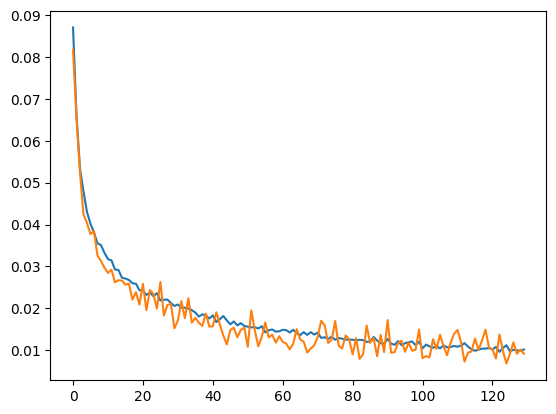

In [23]:
show_losses(tr_tuple, range(130))